# Understanding QMIX: Monotonic Value Function Factorization for MARL

# Table of Contents

- [Introduction: Cooperative MARL & Credit Assignment](#introduction)
- [What is QMIX?](#what-is-qmix)
  - [Core Idea: Value Function Factorization](#core-idea)
  - [The Mixing Network](#the-mixing-network)
  - [Monotonicity Constraint (IQL Principle)](#monotonicity-constraint-iql-principle)
- [Why QMIX? Advantages](#why-qmix)
- [Where and How QMIX is Used](#where-and-how-qmix-is-used)
- [Mathematical Foundation of QMIX](#mathematical-foundation-of-qmix)
  - [Individual Agent Q-Functions ($Q_i$)](#individual-agent-q-functions-qi)
  - [Joint Action-Value Function ($Q_{tot}$)](#joint-action-value-function-q_tot)
  - [Mixing Network Architecture & Monotonicity](#mixing-network-architecture--monotonicity)
  - [Hypernetworks for State-Dependency](#hypernetworks-for-state-dependency)
  - [Loss Function (TD Error on $Q_{tot}$)](#loss-function-td-error-on-q_tot)
  - [Target Network](#target-network)
- [Step-by-Step Explanation of QMIX](#step-by-step-explanation-of-qmix)
- [Key Components of QMIX](#key-components-of-qmix)
  - [Agent Networks ($Q_i$)](#agent-networks-qi)
  - [Mixing Network](#mixing-network)
  - [Hypernetworks](#hypernetworks)
  - [Replay Buffer (Shared)](#replay-buffer-shared)
  - [Target Networks (Agents & Mixer)](#target-networks-agents--mixer)
  - [Action Selection (Decentralized, $\epsilon$-greedy)](#action-selection-decentralized-epsilon-greedy)
  - [Centralized Training](#centralized-training)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Custom Multi-Agent Grid World](#practical-example-custom-multi-agent-grid-world)
  - [Environment Design Rationale](#environment-design-rationale)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Custom Multi-Agent Environment](#creating-the-custom-multi-agent-environment)
- [Implementing the QMIX Algorithm](#implementing-the-qmix-algorithm)
  - [Defining the Agent Network (DRQN or MLP)](#defining-the-agent-network-drqn-or-mlp)
  - [Defining the Mixing Network (with Hypernetworks)](#defining-the-mixing-network-with-hypernetworks)
  - [Defining the Replay Memory](#defining-the-replay-memory)
  - [Soft Update Function](#soft-update-function)
  - [The QMIX Update Step](#the-qmix-update-step)
- [Running the QMIX Algorithm](#running-the-qmix-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization](#initialization)
  - [Training Loop](#training-loop)
- [Visualizing the Learning Process](#visualizing-the-learning-process)
- [Analyzing the Learned Policies (Testing)](#analyzing-the-learned-policies-testing)
- [Common Challenges and Extensions of QMIX](#common-challenges-and-extensions-of-qmix)
- [Conclusion](#conclusion)

## Introduction: Cooperative MARL & Credit Assignment

In cooperative Multi-Agent Reinforcement Learning (MARL), multiple agents collaborate to achieve a common goal, typically receiving a shared team reward. A key challenge in these settings is **credit assignment**: how can an individual agent determine its contribution to the team's success or failure based only on the global reward signal? Simple independent learning (e.g., each agent running DQN) often fails because it treats other agents as part of the non-stationary environment and struggles with credit assignment.

Value decomposition methods, like QMIX, provide a structured approach to address this challenge in cooperative MARL.

## What is QMIX?

QMIX (Q-value Mixing) is an **off-policy, value-based** MARL algorithm designed for cooperative tasks. It adheres to the **centralized training, decentralized execution** paradigm. Its central innovation is learning individual agent utility functions (represented as $Q_i$) and combining them through a **monotonic mixing network** to estimate the joint action-value function ($Q_{tot}$). 

### Core Idea: Value Function Factorization
QMIX assumes that the joint action-value function $Q_{tot}$ for the team can be factorized or represented as a monotonic combination of individual agent utility functions $Q_i$. Each $Q_i(o_i, a_i)$ depends only on the local observation $o_i$ and action $a_i$ of agent $i$.

### The Mixing Network
A separate mixing network takes the values produced by each agent's individual network ($Q_1, ..., Q_N$) as input and outputs the estimated joint action-value $Q_{tot}$. Crucially, this mixing network also takes the global state $x$ as input, allowing the relationship between individual utilities and the team value to depend on the overall situation. This state information is typically used to generate the weights and biases of the mixing network layers via **hypernetworks**.

### Monotonicity Constraint (IQL Principle)
To ensure consistency between decentralized execution (where each agent picks its best action based on $Q_i$) and centralized training (optimizing $Q_{tot}$), QMIX enforces a monotonicity constraint: 
$$ \frac{\partial Q_{tot}}{\partial Q_i} \ge 0 \quad \forall i $$
This means that increasing an individual agent's utility $Q_i$ must never decrease the total team value $Q_{tot}$. This guarantees that an agent maximizing its local $Q_i$ during execution contributes positively towards maximizing the global $Q_{tot}$. QMIX achieves this constraint structurally by ensuring the weights of the mixing network are non-negative.
This constraint embodies the Individual-Global Max (IQL) principle: the joint action that maximizes $Q_{tot}$ is the same as the set of individual actions that maximize each agent's $Q_i$.

## Why QMIX? Advantages

- **Addresses Credit Assignment:** By learning individual $Q_i$ functions that contribute monotonically to $Q_{tot}$, it implicitly handles credit assignment better than methods using only the global reward.
- **Scalability (Action Space):** Unlike methods learning a joint Q-function directly (which scales exponentially with the number of agents and actions), QMIX learns individual $Q_i$ functions and a mixing network, making it more scalable in terms of the joint action space.
- **Decentralized Execution:** Agents can act using only their local $Q_i$ functions after training.
- **State-Dependent Mixing:** Using the global state allows the mixing function to capture complex non-linear relationships between agent utilities that depend on the overall context.

## Where and How QMIX is Used

QMIX is a popular algorithm for cooperative MARL tasks, particularly those with discrete action spaces:

1.  **StarCraft Multi-Agent Challenge (SMAC):** QMIX and its variants achieve strong performance on these benchmark micromanagement tasks.
2.  **Coordination Games:** Grid worlds or other tasks requiring agents to synchronize or coordinate actions.
3.  **Multi-Robot Cooperation:** Cooperative navigation, formation control.

## Mathematical Foundation of QMIX

### Individual Agent Q-Functions ($Q_i$)
Each agent $i$ has a network (often a DRQN - Deep Recurrent Q-Network, if history is needed, or an MLP) that takes its local observation history $\tau_i$ and outputs Q-values for each of its possible actions $a_i$: $Q_i(\tau_i, a_i; \theta_i)$. For simplicity with Markovian states, we use $Q_i(o_i, a_i; \theta_i)$.

### Joint Action-Value Function ($Q_{tot}$)
The mixing network $f_{mix}$ combines the individual Q-values and global state $x$ to produce the joint action-value:
$$ Q_{tot}(x, \mathbf{a}) = f_{mix}(Q_1(o_1, a_1), ..., Q_N(o_N, a_N); x; \phi_{mix}) $$
where $\mathbf{a} = (a_1, ..., a_N)$.

### Mixing Network Architecture & Monotonicity
The mixing network enforces $\frac{\partial Q_{tot}}{\partial Q_i} \ge 0$. This is typically achieved by:
1.  Using non-negative weights in the mixing layers.
2.  Using monotonic activation functions (like ReLU or linear layers where weights are constrained).
The original QMIX paper generates the weights and biases of the mixing layers using separate hypernetworks conditioned on the global state.

### Hypernetworks for State-Dependency
To make the mixing state-dependent, hypernetworks are used. For example, for a mixing layer $Q_{tot} = W_1 \mathbf{Q} + b_1$ (where $\mathbf{Q} = [Q_1, ..., Q_N]^T$):
- A hypernetwork takes global state $x$ as input and outputs the weight matrix $W_1$. The elements of $W_1$ are constrained to be non-negative (e.g., by taking `abs()` or using an ELU activation + 1).
- Another hypernetwork takes $x$ and outputs the bias $b_1$. (The bias doesn't need a positivity constraint).
This is repeated if the mixing network has multiple layers.

### Loss Function (TD Error on $Q_{tot}$)
QMIX uses off-policy data from a replay buffer $\mathcal{D}$. The loss function aims to minimize the TD error for the joint action-value function, similar to DQN:
$$ L(\theta_1, ..., \theta_N, \phi_{mix}) = \mathbb{E}_{(x, \mathbf{a}, r, x') \sim \mathcal{D}} [ (y - Q_{tot}(x, \mathbf{a}))^2 ] $$
The target $y$ is calculated using the **target** agent networks ($Q'_i$) and the **target** mixing network ($f'_{mix}$):
$$ y = r + \gamma Q'_{tot}(x', \mathbf{a}') $$ 
$$ \text{where } \mathbf{a}' = (a'_1, ..., a'_N) \text{ with } a'_i = \arg\max_{a_i} Q'_i(o'_i, a_i) $$
The gradient $\nabla L$ flows back through the main mixing network and *all* main agent networks $Q_i$.

### Target Network
Target networks ($Q'_i$ for each agent, and a target mixing network $f'_{mix}$) are used for stability. They are updated periodically or via soft updates from the main networks.

## Step-by-Step Explanation of QMIX

1.  **Initialize**: For each agent $i$: Agent network $Q_i(\theta_i)$, Target agent network $Q'_i(\theta'_i)$ with $\theta'_i \leftarrow \theta_i$.
2.  **Initialize**: Mixing network $f_{mix}(\phi_{mix})$, Target mixing network $f'_{mix}(\phi'_{mix})$ with $\phi'_{mix} \leftarrow \phi_{mix}$.
3.  **Initialize**: Replay buffer $\mathcal{D}$. Hyperparameters (buffer size, batch size, $\gamma$, $\tau$, learning rates, $\epsilon$).
4.  **For each episode**:
    a.  Get initial joint observation $o=(o_1, ..., o_N)$ and global state $x$.
    b.  **For each step $t$**:
        i.   For each agent $i$, choose action $a_i$ using $\epsilon$-greedy on $Q_i(o_i, \cdot)$.
        ii.  Execute joint action $\mathbf{a}=(a_1, ..., a_N)$, observe shared reward $r$, next joint observation $o'$, next global state $x'$, and done flag $d$.
        iii. Store transition $(o, \mathbf{a}, r, o', x, x', d)$ in $\mathcal{D}$.
        iv.  $o \leftarrow o', x \leftarrow x'$.
        v.   **Update Step (if buffer has enough samples)**:
            1.  Sample mini-batch of $B$ transitions from $\mathcal{D}$.
            2.  For each transition $j$ in the batch:
                - Calculate target $Q'_{tot,j}$:
                    - For each agent $i$, find $a'_{i,j} = \arg\max_{a} Q'_{i}(o'_{i,j}, a)$.
                    - Get $Q'_{i,j} = Q'_{i}(o'_{i,j}, a'_{i,j})$.
                    - Compute $Q'_{tot,j} = f'_{mix}(Q'_{1,j}, ..., Q'_{N,j}; x'_{j})$.
                - Compute TD target $y_j = r_j + \gamma (1-d_j) Q'_{tot,j}$.
                - Calculate current $Q_{tot,j}$:
                    - For each agent $i$, get $Q_{i,j} = Q_{i}(o_{i,j}, a_{i,j})$ (using action $a_{i,j}$ from buffer).
                    - Compute $Q_{tot,j} = f_{mix}(Q_{1,j}, ..., Q_{N,j}; x_{j})$.
            3.  Compute loss $L = \frac{1}{B} \sum_j (y_j - Q_{tot,j})^2$.
            4.  Perform gradient descent step on $L$ wrt $\theta_1, ..., \theta_N, \phi_{mix}$.
            5.  Update target networks ($Q'_i$ and $f'_{mix}$) via soft updates (or periodic hard updates).
        vi.  If done, break step loop.
5.  **Repeat**: Until convergence.

## Key Components of QMIX

### Agent Networks ($Q_i$)
- Learn individual utility/Q-functions based on local observations.
- Can be MLPs or DRQNs (if history matters).

### Mixing Network
- Takes individual $Q_i$ values and global state $x$ to produce $Q_{tot}$.
- Enforces monotonicity constraint ($\partial Q_{tot} / \partial Q_i \ge 0$).

### Hypernetworks
- Generate the weights/biases of the mixing network conditioned on the global state $x$.
- Ensures mixing is state-dependent and weights are non-negative.

### Replay Buffer (Shared)
- Stores joint transitions for off-policy learning.

### Target Networks (Agents & Mixer)
- Stabilize TD target calculation.

### Action Selection (Decentralized, $\epsilon$-greedy)
- Each agent acts greedily (or $\epsilon$-greedily) based *only* on its own $Q_i$.

### Centralized Training
- Updates use joint information (global state $x$, all $Q_i$ values) via the mixing network.

### Hyperparameters
- Standard RL params ($\gamma$, $\epsilon$, learning rates, $\tau$, buffer/batch size).
- Mixing network architecture, hypernetwork architecture.

## Practical Example: Custom Multi-Agent Grid World

### Environment Design Rationale
The cooperative 2-agent grid world is suitable for demonstrating QMIX's value decomposition in a discrete setting.

**Environment Details:**
- **Global State ($x$):** Concatenation of normalized positions of both agents and both goals `(r1, c1, r2, c2, g1r, g1c, g2r, g2c)`.
- **Local Observation ($o_i$):** Agent $i$'s normalized position, other agent's normalized position, agent $i$'s goal normalized position `(self_r, self_c, other_r, other_c, goal_i_r, goal_i_c)`.
- **Actions/Rewards:** As defined previously.


# Setting up the Environment

Import libraries.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque, defaultdict
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable, Any
import copy

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

%matplotlib inline

Using device: cpu


# Creating the Custom Multi-Agent Environment

Using the `MultiAgentGridEnv` from MADDPG notebook, adding a method to get the global state.

In [2]:
class MultiAgentGridEnv:
    """
    Simple 2-Agent Cooperative Grid World.
    Agents must reach their respective goals simultaneously.
    Observation includes agent positions and goal positions.
    Rewards are shared.
    """
    def __init__(self, size: int = 5, num_agents: int = 2):
        self.size: int = size
        self.num_agents: int = num_agents
        self.action_dim: int = 4 # U, D, L, R
        self.action_map: Dict[int, Tuple[int, int]] = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
        self.actions: List[int] = list(self.action_map.keys())

        # Define fixed start and goal positions for simplicity
        self.start_positions: List[Tuple[int, int]] = [(0, 0), (size - 1, size - 1)]
        self.goal_positions: List[Tuple[int, int]] = [(size - 1, 0), (0, size - 1)]
        if num_agents != 2:
             raise NotImplementedError("Currently supports only 2 agents.")

        self.agent_positions: List[Tuple[int, int]] = list(self.start_positions)

        # Observation space for agent i: (self_r, self_c, other_r, other_c, goal_i_r, goal_i_c)
        # Normalized between 0 and 1
        self.observation_dim_per_agent: int = 6 
        self.max_coord = float(self.size - 1)

    def _normalize_pos(self, pos: Tuple[int, int]) -> Tuple[float, float]:
        """ Normalizes a grid position. """
        r, c = pos
        return (r / self.max_coord, c / self.max_coord) if self.max_coord > 0 else (0.0, 0.0)
        
    def _get_observation(self, agent_id: int) -> np.ndarray:
        """ Get normalized local observation for a specific agent. """
        obs = []
        # Self position
        self_pos_norm = self._normalize_pos(self.agent_positions[agent_id])
        obs.extend(self_pos_norm)
        # Other agent position
        other_id = 1 - agent_id
        other_pos_norm = self._normalize_pos(self.agent_positions[other_id])
        obs.extend(other_pos_norm)
        # Self goal position
        goal_pos_norm = self._normalize_pos(self.goal_positions[agent_id])
        obs.extend(goal_pos_norm)
        return np.array(obs, dtype=np.float32)

    def get_joint_observation(self) -> List[np.ndarray]:
        """ Get list of observations for all agents. """
        return [self._get_observation(i) for i in range(self.num_agents)]
        
    def reset(self) -> List[np.ndarray]:
        """ Resets environment, returns list of initial observations. """
        self.agent_positions = list(self.start_positions)
        return self.get_joint_observation()

    def step(self, actions: List[int]) -> Tuple[List[np.ndarray], List[float], bool]:
        """
        Performs one step for all agents.
        
        Parameters:
        - actions (List[int]): List of actions, one for each agent.
        
        Returns:
        - Tuple[List[np.ndarray], List[float], bool]: 
            - List of next observations for each agent.
            - List of rewards for each agent (shared reward).
            - Global done flag.
        """
        if len(actions) != self.num_agents:
            raise ValueError(f"Expected {self.num_agents} actions, got {len(actions)}")
            
        next_positions: List[Tuple[int, int]] = list(self.agent_positions) # Start with current
        total_dist_reduction = 0.0
        hit_wall_penalty = 0.0

        for i in range(self.num_agents):
            current_pos = self.agent_positions[i]
            if current_pos == self.goal_positions[i]: # Agent already at goal, doesn't move
                continue 
                
            action = actions[i]
            dr, dc = self.action_map[action]
            next_r, next_c = current_pos[0] + dr, current_pos[1] + dc
            
            # Check bounds and update position
            if 0 <= next_r < self.size and 0 <= next_c < self.size:
                next_positions[i] = (next_r, next_c)
            else:
                hit_wall_penalty -= 0.5 # Penalty for hitting wall
                next_positions[i] = current_pos # Stay in place
                
        # Simple collision handling: if agents move to same spot, they bounce back
        if self.num_agents == 2 and next_positions[0] == next_positions[1]:
            next_positions = list(self.agent_positions) # Revert to previous positions
            hit_wall_penalty -= 0.5 # Treat as a penalty (like hitting a wall)
            
        self.agent_positions = next_positions

        # Calculate reward and done flag
        done = all(self.agent_positions[i] == self.goal_positions[i] for i in range(self.num_agents))
        
        if done:
            reward = 10.0 # Large reward for cooperative success
        else:
            # Distance-based reward (negative sum of distances to goals)
            dist_reward = 0.0
            for i in range(self.num_agents):
                dist = abs(self.agent_positions[i][0] - self.goal_positions[i][0]) + \
                       abs(self.agent_positions[i][1] - self.goal_positions[i][1])
                dist_reward -= dist * 0.1 # Scaled negative distance
            
            reward = -0.05 + dist_reward + hit_wall_penalty # Small step penalty + distance + wall penalty

        next_observations = self.get_joint_observation()
        # Shared reward
        rewards = [reward] * self.num_agents 
        
        return next_observations, rewards, done

In [3]:
class MultiAgentGridEnv_QMIX(MultiAgentGridEnv):
    """ Adds global state method to the MA Grid Env. """
    def __init__(self, size: int = 5, num_agents: int = 2):
        super().__init__(size=size, num_agents=num_agents)
        # Global state: (r1,c1, r2,c2, g1r,g1c, g2r,g2c) normalized
        self.global_state_dim = self.num_agents * 4 

    def get_global_state(self) -> np.ndarray:
        """ Returns the normalized global state. """
        state = []
        # Agent positions
        for i in range(self.num_agents):
            state.extend(self._normalize_pos(self.agent_positions[i]))
        # Goal positions
        for i in range(self.num_agents):
            state.extend(self._normalize_pos(self.goal_positions[i]))
        return np.array(state, dtype=np.float32)
        
    def reset_qmix(self) -> Tuple[List[np.ndarray], np.ndarray]:
        """ Resets and returns list of obs and global state. """
        obs_list = super().reset()
        global_state = self.get_global_state()
        return obs_list, global_state

    def step_qmix(self, actions: List[int]) -> Tuple[List[np.ndarray], np.ndarray, float, bool]:
        """ Steps env, returns list of obs, global state, shared reward, done. """
        next_obs_list, rewards, done = super().step(actions)
        next_global_state = self.get_global_state()
        shared_reward = rewards[0] # Use the shared reward
        return next_obs_list, next_global_state, shared_reward, done

Instantiate and test the environment.

In [4]:
qmix_env = MultiAgentGridEnv_QMIX(size=5, num_agents=2)
obs_list_qmix, global_state_qmix = qmix_env.reset_qmix()
n_agents_qmix = qmix_env.num_agents
obs_dim_qmix = qmix_env.observation_dim_per_agent
global_state_dim_qmix = qmix_env.global_state_dim
action_dim_qmix = qmix_env.action_dim

print(f"QMIX Env Size: {qmix_env.size}x{qmix_env.size}")
print(f"Num Agents: {n_agents_qmix}")
print(f"Obs Dim per Agent: {obs_dim_qmix}")
print(f"Global State Dim: {global_state_dim_qmix}")
print(f"Action Dim per Agent: {action_dim_qmix}")
print(f"Initial Obs List: {obs_list_qmix}")
print(f"Initial Global State: {global_state_qmix}")

QMIX Env Size: 5x5
Num Agents: 2
Obs Dim per Agent: 6
Global State Dim: 8
Action Dim per Agent: 4
Initial Obs List: [array([0., 0., 1., 1., 1., 0.], dtype=float32), array([1., 1., 0., 0., 0., 1.], dtype=float32)]
Initial Global State: [0. 0. 1. 1. 1. 0. 0. 1.]


# Implementing the QMIX Algorithm

### Defining the Agent Network (DRQN or MLP)

Outputs $Q_i(o_i, a)$ for all actions $a$. We'll use a simple MLP here. For environments with partial observability, a DRQN (Deep Recurrent Q-Network) using an LSTM or GRU would be more standard.

In [5]:
class AgentQNetwork(nn.Module):
    """ Individual Agent Q-Network for QMIX. Outputs Q-values for all actions. """
    def __init__(self, obs_dim: int, action_dim: int):
        super(AgentQNetwork, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 64) # Smaller network for individual agent
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim) # Output Q-value for each action

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        """ Maps observation to Q-values for all actions. """
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x)
        return q_values

### Defining the Mixing Network (with Hypernetworks)

Combines individual $Q_i$ values monotonically, conditioned on the global state.

In [6]:
class QMixer(nn.Module):
    """ Mixing Network for QMIX with Hypernetworks. """
    def __init__(self, num_agents: int, global_state_dim: int, mixing_embed_dim: int = 32):
        super(QMixer, self).__init__()
        self.num_agents = num_agents
        self.state_dim = global_state_dim
        self.embed_dim = mixing_embed_dim

        # Hypernetwork to generate weights for the first mixing layer
        # Input: global_state, Output: weights shaped (num_agents * embed_dim)
        self.hyper_w1 = nn.Sequential(
            nn.Linear(self.state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, self.num_agents * self.embed_dim)
        )
        # Hypernetwork for bias of the first mixing layer
        # Input: global_state, Output: bias shaped (embed_dim)
        self.hyper_b1 = nn.Linear(self.state_dim, self.embed_dim)

        # Hypernetwork for the second mixing layer (optional, can be single layer)
        # Input: global_state, Output: weights shaped (embed_dim * 1)
        self.hyper_w2 = nn.Sequential(
            nn.Linear(self.state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, self.embed_dim) # Output has size embed_dim
        )
        # Hypernetwork for the final bias (scalar)
        # Input: global_state, Output: bias (scalar)
        self.hyper_b2 = nn.Sequential(
            nn.Linear(self.state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, agent_qs: torch.Tensor, global_state: torch.Tensor) -> torch.Tensor:
        """
        Mixes individual agent Q-values to produce Q_tot.
        
        Parameters:
        - agent_qs (torch.Tensor): Tensor of individual Q-values, shape (batch_size, num_agents).
        - global_state (torch.Tensor): Tensor of global states, shape (batch_size, global_state_dim).
        
        Returns:
        - torch.Tensor: Estimated Q_tot values, shape (batch_size, 1).
        """
        batch_size = agent_qs.size(0)
        # Reshape agent_qs to (batch_size, 1, num_agents) for batch matrix multiplication
        agent_qs_reshaped = agent_qs.view(batch_size, 1, self.num_agents)

        # --- First Mixing Layer --- 
        # Generate weights and ensure non-negativity
        w1 = torch.abs(self.hyper_w1(global_state)) # abs() ensures non-negative weights
        # Reshape weights to (batch_size, num_agents, embed_dim)
        w1 = w1.view(batch_size, self.num_agents, self.embed_dim)
        
        # Generate bias
        b1 = self.hyper_b1(global_state)
        # Reshape bias to (batch_size, 1, embed_dim)
        b1 = b1.view(batch_size, 1, self.embed_dim)

        # Apply first layer: Q_hidden = Q_agents * W1 + b1
        hidden = F.elu(torch.bmm(agent_qs_reshaped, w1) + b1)
        # shape: (batch_size, 1, embed_dim)

        # --- Second Mixing Layer --- 
        # Generate weights and ensure non-negativity
        w2 = torch.abs(self.hyper_w2(global_state))
        # Reshape weights to (batch_size, embed_dim, 1)
        w2 = w2.view(batch_size, self.embed_dim, 1)
        
        # Generate bias
        b2 = self.hyper_b2(global_state)
        # Reshape bias to (batch_size, 1, 1)
        b2 = b2.view(batch_size, 1, 1)

        # Apply second layer: Q_tot = Q_hidden * W2 + b2
        q_tot = torch.bmm(hidden, w2) + b2
        # shape: (batch_size, 1, 1)

        return q_tot.view(batch_size, 1) # Return shape (batch_size, 1)

### Defining the Replay Memory

Stores joint transitions, including global state.

In [7]:
# Define transition structure for QMIX buffer
QMIXTransition = namedtuple('QMIXTransition', 
                            ('obs_list', 'actions_list', 'reward', 
                             'next_obs_list', 'global_state', 
                             'next_global_state', 'done'))

class QMIXReplayBuffer:
    def __init__(self, capacity: int):
        self.memory = deque([], maxlen=capacity)

    def push(self, obs_list: List[np.ndarray], actions_list: List[int], reward: float, 
               next_obs_list: List[np.ndarray], global_state: np.ndarray,
               next_global_state: np.ndarray, done: bool) -> None:
        """ Saves a joint transition. """
        # Store as numpy arrays or primitive types
        self.memory.append(QMIXTransition(obs_list, actions_list, reward, 
                                          next_obs_list, global_state,
                                          next_global_state, done))

    def sample(self, batch_size: int) -> Optional[QMIXTransition]:
        """ Samples a batch of experiences and converts to tensors. """
        if len(self.memory) < batch_size:
            return None
        
        transitions = random.sample(self.memory, batch_size)
        
        # Unzip and convert to numpy arrays first for easier stacking
        obs_l, act_l, rew_l, next_obs_l, gs_l, next_gs_l, done_l = zip(*transitions)
        
        num_agents = len(obs_l[0])
        obs_dim = obs_l[0][0].shape[0]
        global_dim = gs_l[0].shape[0]
        
        # Stack observations: list of lists -> (batch, agent, dim)
        obs_arr = np.array(obs_l, dtype=np.float32).reshape(batch_size, num_agents, obs_dim)
        next_obs_arr = np.array(next_obs_l, dtype=np.float32).reshape(batch_size, num_agents, obs_dim)
        
        # Stack actions, rewards, dones, global states
        act_arr = np.array(act_l, dtype=np.int64) # Action indices
        rew_arr = np.array(rew_l, dtype=np.float32)
        gs_arr = np.array(gs_l, dtype=np.float32).reshape(batch_size, global_dim)
        next_gs_arr = np.array(next_gs_l, dtype=np.float32).reshape(batch_size, global_dim)
        done_arr = np.array(done_l, dtype=np.float32)
        
        # Convert to tensors
        return QMIXTransition(
            torch.from_numpy(obs_arr).to(device),
            torch.from_numpy(act_arr).to(device),
            torch.from_numpy(rew_arr).unsqueeze(1).to(device),
            torch.from_numpy(next_obs_arr).to(device),
            torch.from_numpy(gs_arr).to(device),
            torch.from_numpy(next_gs_arr).to(device),
            torch.from_numpy(done_arr).unsqueeze(1).to(device)
        )

    def __len__(self) -> int:
        return len(self.memory)

### Soft Update Function

Standard soft update.

In [8]:
def soft_update(target_net: nn.Module, main_net: nn.Module, tau: float) -> None:
    for target_param, main_param in zip(target_net.parameters(), main_net.parameters()):
        target_param.data.copy_(tau * main_param.data + (1.0 - tau) * target_param.data)

### The QMIX Update Step

Function to perform the centralized QMIX update.

In [9]:
def update_qmix(memory: QMIXReplayBuffer,
                  batch_size: int,
                  agent_networks: List[AgentQNetwork],
                  target_agent_networks: List[AgentQNetwork],
                  mixer: QMixer,
                  target_mixer: QMixer,
                  optimizer: optim.Optimizer, # Single optimizer for all agent + mixer params
                  gamma: float,
                  tau: float,
                  num_agents: int,
                  action_dim: int) -> float:
    """
    Performs one QMIX update step for all agents and the mixer.
    
    Returns:
    - float: The TD loss value.
    """
    if len(memory) < batch_size:
        return 0.0

    batch = memory.sample(batch_size)
    if batch is None: return 0.0
    
    obs_b, act_b, rew_b, next_obs_b, gs_b, next_gs_b, done_b = batch
    # obs_b shape: (batch_size, num_agents, obs_dim)
    # act_b shape: (batch_size, num_agents) -> action indices
    # rew_b shape: (batch_size, 1)
    # gs_b shape: (batch_size, global_state_dim)
    # done_b shape: (batch_size, 1)

    # --- Calculate Target Q_tot' --- 
    target_agent_qs_list = []
    with torch.no_grad():
        for i in range(num_agents):
            # Get Q-values for next observations from target agent network
            target_q_values_next = target_agent_networks[i](next_obs_b[:, i, :])
            # Select action that maximizes target Q_i
            max_actions_next = target_q_values_next.argmax(dim=1, keepdim=True) # Shape: (batch_size, 1)
            # Get the Q-value corresponding to that max action
            max_target_q_next = torch.gather(target_q_values_next, 1, max_actions_next)
            target_agent_qs_list.append(max_target_q_next)
        
        # Stack target agent Qs: (batch_size, num_agents)
        target_agent_qs = torch.cat(target_agent_qs_list, dim=1)
        
        # Calculate target Q_tot' using target mixer
        q_tot_target = target_mixer(target_agent_qs, next_gs_b)
        
        # Calculate TD target y = r + gamma * Q_tot' * (1 - done)
        y = rew_b + gamma * (1.0 - done_b) * q_tot_target

    # --- Calculate Current Q_tot --- 
    current_agent_qs_list = []
    for i in range(num_agents):
        # Get Q-values for current observations from main agent network
        q_values_current = agent_networks[i](obs_b[:, i, :])
        # Select the Q-value corresponding to the action *taken* in the buffer
        action_i = act_b[:, i].unsqueeze(1) # Shape: (batch_size, 1)
        q_current_i = torch.gather(q_values_current, 1, action_i)
        current_agent_qs_list.append(q_current_i)
        
    # Stack current agent Qs: (batch_size, num_agents)
    current_agent_qs = torch.cat(current_agent_qs_list, dim=1)
    
    # Calculate current Q_tot using main mixer
    q_tot_current = mixer(current_agent_qs, gs_b)

    # --- Compute Loss and Optimize --- 
    loss = F.mse_loss(q_tot_current, y)
    
    optimizer.zero_grad()
    loss.backward()
    # Gradient clipping (optional, often useful)
    # total_norm = torch.nn.utils.clip_grad_norm_([param for net in agent_networks for param in net.parameters()] + 
    #                                            list(mixer.parameters()), max_norm=1.0)
    optimizer.step()

    # --- Update Target Networks --- 
    for i in range(num_agents):
        soft_update(target_agent_networks[i], agent_networks[i], tau)
    soft_update(target_mixer, mixer, tau)

    return loss.item()

# Running the QMIX Algorithm

### Hyperparameter Setup

In [10]:
# Hyperparameters for QMIX on Custom Multi-Agent Grid World
BUFFER_SIZE_QMIX = int(5e4)  # Smaller buffer might be okay for simpler env
BATCH_SIZE_QMIX = 64
GAMMA_QMIX = 0.99
TAU_QMIX = 1e-3           # Soft update factor
LR_QMIX = 5e-4            # Learning rate for agent nets and mixer
EPSILON_QMIX_START = 1.0
EPSILON_QMIX_END = 0.05
EPSILON_QMIX_DECAY = 100000 # Decay over N steps
MIXING_EMBED_DIM = 32     # Embedding dimension in the mixing network
HYPERNET_HIDDEN = 64      # Hidden size for hypernetworks

NUM_EPISODES_QMIX = 600
MAX_STEPS_PER_EPISODE_QMIX = 100
UPDATE_EVERY_QMIX = 4      # Perform update every N environment steps
TARGET_UPDATE_FREQ_QMIX = 100 # Steps between target network soft updates (alternative)
USE_SOFT_UPDATE = True       # Use soft updates (True) or periodic hard updates (False)

### Initialization

In [11]:
# Initialize Environment
env_qmix = MultiAgentGridEnv_QMIX(size=5, num_agents=2)
num_agents_qmix = env_qmix.num_agents
obs_dim_qmix = env_qmix.observation_dim_per_agent
global_state_dim_qmix = env_qmix.global_state_dim
action_dim_qmix = env_qmix.action_dim

# Initialize Agent Networks and Target Networks
agent_networks = [AgentQNetwork(obs_dim_qmix, action_dim_qmix).to(device) for _ in range(num_agents_qmix)]
target_agent_networks = [AgentQNetwork(obs_dim_qmix, action_dim_qmix).to(device) for _ in range(num_agents_qmix)]
for i in range(num_agents_qmix):
    target_agent_networks[i].load_state_dict(agent_networks[i].state_dict())
    for p in target_agent_networks[i].parameters(): p.requires_grad = False

# Initialize Mixing Network and Target Mixing Network
mixer = QMixer(num_agents_qmix, global_state_dim_qmix, MIXING_EMBED_DIM).to(device)
target_mixer = QMixer(num_agents_qmix, global_state_dim_qmix, MIXING_EMBED_DIM).to(device)
target_mixer.load_state_dict(mixer.state_dict())
for p in target_mixer.parameters(): p.requires_grad = False

# Collect all parameters for the single optimizer
all_params = list(mixer.parameters())
for net in agent_networks:
    all_params.extend(list(net.parameters()))

# Initialize Optimizer
optimizer_qmix = optim.Adam(all_params, lr=LR_QMIX)

# Initialize Replay Buffer
memory_qmix = QMIXReplayBuffer(BUFFER_SIZE_QMIX)

# Lists for plotting
qmix_episode_rewards = []
qmix_episode_losses = []
qmix_episode_epsilons = []

### Training Loop

In [12]:
print("Starting QMIX Training...")

total_steps_qmix = 0
epsilon = EPSILON_QMIX_START

for i_episode in range(1, NUM_EPISODES_QMIX + 1):
    obs_list_np, global_state_np = env_qmix.reset_qmix()
    episode_reward = 0
    episode_loss = 0
    num_updates_ep = 0

    for t in range(MAX_STEPS_PER_EPISODE_QMIX):
        # --- Action Selection (Decentralized Epsilon-Greedy) --- 
        actions_list = []
        for i in range(num_agents_qmix):
            obs_tensor = torch.from_numpy(obs_list_np[i]).float().to(device)
            agent_networks[i].eval() # Eval mode for selection
            with torch.no_grad():
                q_values = agent_networks[i](obs_tensor)
            agent_networks[i].train() # Back to train mode
            
            if random.random() < epsilon:
                action = random.randrange(action_dim_qmix)
            else:
                action = q_values.argmax().item()
            actions_list.append(action)
        
        # --- Environment Interaction --- 
        next_obs_list_np, next_global_state_np, reward, done = env_qmix.step_qmix(actions_list)
        
        # --- Store Experience --- 
        memory_qmix.push(obs_list_np, actions_list, reward, next_obs_list_np, 
                           global_state_np, next_global_state_np, done)

        # Update current states/obs
        obs_list_np = next_obs_list_np
        global_state_np = next_global_state_np
        
        episode_reward += reward
        total_steps_qmix += 1

        # --- Update Networks --- 
        if len(memory_qmix) > BATCH_SIZE_QMIX and total_steps_qmix % UPDATE_EVERY_QMIX == 0:
            loss = update_qmix(
                memory_qmix, BATCH_SIZE_QMIX,
                agent_networks, target_agent_networks,
                mixer, target_mixer,
                optimizer_qmix,
                GAMMA_QMIX, TAU_QMIX if USE_SOFT_UPDATE else 1.0, # Tau=1.0 if hard update
                num_agents_qmix, action_dim_qmix
            )
            episode_loss += loss
            num_updates_ep += 1
            
            # --- Target Network Update Logic --- 
            if not USE_SOFT_UPDATE and total_steps_qmix % TARGET_UPDATE_FREQ_QMIX == 0:
                # Hard update periodically
                for i in range(num_agents_qmix):
                    target_agent_networks[i].load_state_dict(agent_networks[i].state_dict())
                target_mixer.load_state_dict(mixer.state_dict())
            # Soft update happens inside update_qmix if USE_SOFT_UPDATE is True

        # Decay epsilon (step-based decay)
        epsilon = max(EPSILON_QMIX_END, EPSILON_QMIX_START - total_steps_qmix / EPSILON_QMIX_DECAY * (EPSILON_QMIX_START - EPSILON_QMIX_END))

        if done:
            break
            
    # --- End of Episode --- 
    qmix_episode_rewards.append(episode_reward)
    qmix_episode_losses.append(episode_loss / num_updates_ep if num_updates_ep > 0 else 0)
    qmix_episode_epsilons.append(epsilon)

    # Print progress
    if i_episode % 50 == 0:
        avg_reward = np.mean(qmix_episode_rewards[-50:])
        avg_loss = np.mean(qmix_episode_losses[-50:])
        print(f"Ep {i_episode}/{NUM_EPISODES_QMIX} | Steps: {total_steps_qmix} | Avg Reward: {avg_reward:.2f} | Avg Loss: {avg_loss:.4f} | Eps: {epsilon:.3f}")

print("Training Finished (QMIX).")

Starting QMIX Training...
Ep 50/600 | Steps: 3981 | Avg Reward: -70.69 | Avg Loss: 0.3158 | Eps: 0.962
Ep 100/600 | Steps: 7651 | Avg Reward: -50.70 | Avg Loss: 0.0936 | Eps: 0.927
Ep 150/600 | Steps: 10213 | Avg Reward: -32.85 | Avg Loss: 0.0371 | Eps: 0.903
Ep 200/600 | Steps: 12701 | Avg Reward: -27.53 | Avg Loss: 0.0442 | Eps: 0.879
Ep 250/600 | Steps: 15222 | Avg Reward: -24.79 | Avg Loss: 0.0468 | Eps: 0.855
Ep 300/600 | Steps: 17356 | Avg Reward: -19.04 | Avg Loss: 0.0500 | Eps: 0.835
Ep 350/600 | Steps: 19198 | Avg Reward: -14.75 | Avg Loss: 0.0539 | Eps: 0.818
Ep 400/600 | Steps: 20969 | Avg Reward: -13.01 | Avg Loss: 0.0618 | Eps: 0.801
Ep 450/600 | Steps: 22741 | Avg Reward: -13.86 | Avg Loss: 0.0642 | Eps: 0.784
Ep 500/600 | Steps: 24157 | Avg Reward: -7.86 | Avg Loss: 0.0676 | Eps: 0.771
Ep 550/600 | Steps: 25939 | Avg Reward: -13.20 | Avg Loss: 0.0675 | Eps: 0.754
Ep 600/600 | Steps: 27128 | Avg Reward: -5.17 | Avg Loss: 0.0629 | Eps: 0.742
Training Finished (QMIX).


# Visualizing the Learning Process

Plot episode rewards, TD loss, and epsilon decay.

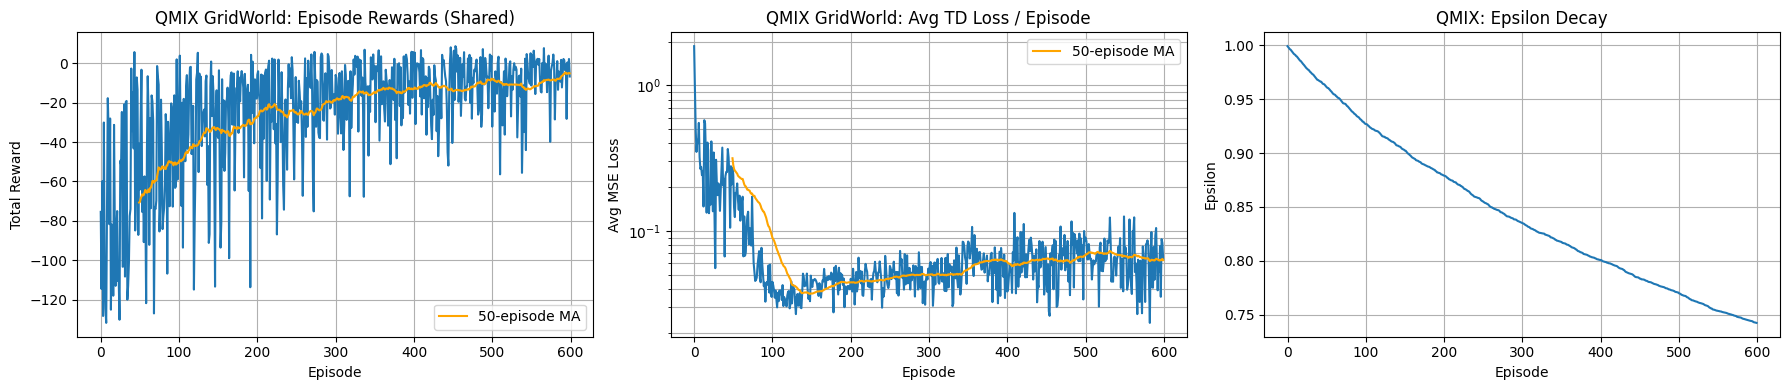

In [13]:
# Plotting results for QMIX
plt.figure(figsize=(18, 4))

# Episode Rewards
plt.subplot(1, 3, 1)
plt.plot(qmix_episode_rewards)
plt.title('QMIX GridWorld: Episode Rewards (Shared)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
if len(qmix_episode_rewards) >= 50:
    rewards_ma_qmix = np.convolve(qmix_episode_rewards, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(len(rewards_ma_qmix)) + 49, rewards_ma_qmix, label='50-episode MA', color='orange')
    plt.legend()

# TD Loss
plt.subplot(1, 3, 2)
plt.plot(qmix_episode_losses)
plt.title('QMIX GridWorld: Avg TD Loss / Episode')
plt.xlabel('Episode')
plt.ylabel('Avg MSE Loss')
plt.yscale('log') # Use log scale if loss varies greatly
plt.grid(True, which='both')
if len(qmix_episode_losses) >= 50:
    loss_ma_qmix = np.convolve(qmix_episode_losses, np.ones(50)/50, mode='valid')
    # Avoid plotting log(0) or negative values if loss goes very low
    valid_indices = np.where(loss_ma_qmix > 1e-8)[0] 
    if len(valid_indices) > 0:
        plt.plot(np.arange(len(loss_ma_qmix))[valid_indices] + 49, loss_ma_qmix[valid_indices], label='50-episode MA', color='orange')
        plt.legend()

# Epsilon
plt.subplot(1, 3, 3)
plt.plot(qmix_episode_epsilons)
plt.title('QMIX: Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)

plt.tight_layout()
plt.show()

**Analysis of QMIX Learning Curves (GridWorld - Shared Reward):**

1.  **Episode Rewards (Shared):**
    *   **Observation:** The learning process shows a clear, albeit slow and noisy, improvement trend. The total shared reward per episode starts very low (around -120) and is extremely volatile. The 50-episode moving average (orange line) illustrates a distinct upward climb, particularly noticeable from episode 100 onwards, eventually reaching a plateau fluctuating around -10 to -20 by episode 500-600. Despite the average improvement, the raw episode rewards (blue line) maintain a very high degree of variance throughout the entire 600 episodes, frequently swinging between near-zero values and significantly negative outcomes.
    *   **Interpretation:** This indicates that the QMIX agent team is learning to coordinate towards achieving higher shared rewards, moving significantly away from the initial poor performance. The gradual climb of the moving average confirms successful learning over a longer timescale. However, the persistent high variance is characteristic of challenges in multi-agent coordination. QMIX relies on individual agents acting greedily based on their local Q-values, combined via a monotonic mixing network. While this structure aids learning, finding consistently optimal *joint* actions remains difficult, leading to episodes where uncoordinated or suboptimal choices result in poor rewards, hence the volatility.

2.  **Avg TD Loss / Episode:**
    *   **Observation:** Plotted on a logarithmic scale, the average TD (Temporal Difference) loss for the mixing network shows a very pronounced drop within the first 100 episodes, decreasing by roughly two orders of magnitude. After this rapid initial decrease, the loss stabilizes at a low average level (around 10^-2 or 0.01), exhibiting moderate fluctuations for the remainder of the training. The moving average confirms this convergence pattern.
    *   **Interpretation:** This plot is crucial as it reflects how well the centralized mixing network learns to approximate the joint action-value function (Q_tot) based on the individual agents' Q-values (Q_i). The sharp initial drop signifies that the mixing network quickly becomes proficient at representing the team's value function based on the agents' current estimates. The subsequent stabilization at a low value indicates that the value function learning component of QMIX is working effectively and providing a consistent basis for selecting joint actions, even while the agents' policies (and thus their Q_i values) might still be evolving.

3.  **Epsilon Decay:**
    *   **Observation:** The exploration parameter, epsilon, follows a predefined decay schedule, decreasing steadily from 1.0 at the beginning to approximately 0.74 by episode 600. The decay appears relatively slow and potentially linear or mildly exponential over this period.
    *   **Interpretation:** This shows the standard epsilon-greedy exploration strategy used with Q-learning based methods. Starting with full exploration (epsilon=1.0), the agents gradually reduce their tendency to take random actions, increasingly exploiting the learned Q-values. The relatively high epsilon value remaining even at episode 600 suggests that substantial exploration is maintained throughout the depicted training run. This continued exploration likely contributes to the high variance observed in the rewards plot, as agents frequently deviate from the current greedy policy. While important for discovering better strategies, this slow decay might also hinder faster convergence to a fully stable, exploitative policy.

**Overall Conclusion:**
QMIX demonstrates successful learning on the multi-agent GridWorld task, significantly improving the shared team reward over 600 episodes. The core mechanism, learning individual Q-functions and combining them via a well-converging mixing network (indicated by the low TD loss), proves effective for value estimation. However, similar to MADDPG, the overall team performance remains highly volatile, suggesting that achieving consistent, optimal coordination based on the decomposed value functions is challenging. The slow epsilon decay likely contributes to this ongoing variance by maintaining a significant level of exploration throughout the training period shown.

# Analyzing the Learned Policies (Testing)

Test the agents acting decentrally using the greedy policy derived from their learned $Q_i$ networks.

In [14]:
def test_qmix_agents(agent_nets: List[AgentQNetwork], 
                     env_instance: MultiAgentGridEnv_QMIX, 
                     num_episodes: int = 5, 
                     seed_offset: int = 6000) -> None:
    """ Tests the trained QMIX agents acting decentrally (greedy). """
    print(f"\n--- Testing QMIX Agents ({num_episodes} episodes) ---")
    all_episode_rewards = []

    for i in range(num_episodes):
        obs_list_np, _ = env_instance.reset_qmix()
        episode_reward = 0
        done = False
        t = 0

        while not done and t < MAX_STEPS_PER_EPISODE_QMIX:
            actions_list = []
            for agent_id in range(env_instance.num_agents):
                obs_tensor = torch.from_numpy(obs_list_np[agent_id]).float().to(device)
                agent_nets[agent_id].eval() # Set to eval mode
                with torch.no_grad():
                    q_values = agent_nets[agent_id](obs_tensor)
                    action = q_values.argmax().item() # Greedy action
                actions_list.append(action)
            
            # Step environment
            next_obs_list_np, _, reward, done = env_instance.step_qmix(actions_list)
            
            # Update observations
            obs_list_np = next_obs_list_np
            episode_reward += reward
            t += 1
            
        print(f"Test Episode {i+1}: Reward = {episode_reward:.2f}, Length = {t}")
        all_episode_rewards.append(episode_reward)

    print(f"--- Testing Complete. Average Reward: {np.mean(all_episode_rewards):.2f} ---")

# Run test episodes
test_qmix_agents(agent_networks, env_qmix, num_episodes=5)


--- Testing QMIX Agents (5 episodes) ---
Test Episode 1: Reward = 8.65, Length = 4
Test Episode 2: Reward = 8.65, Length = 4
Test Episode 3: Reward = 8.65, Length = 4
Test Episode 4: Reward = 8.65, Length = 4
Test Episode 5: Reward = 8.65, Length = 4
--- Testing Complete. Average Reward: 8.65 ---


## Common Challenges and Extensions of QMIX

**Challenge: Limited Representational Capacity**
*   **Problem:** The monotonicity constraint ($\partial Q_{tot} / \partial Q_i \ge 0$) limits the class of joint action-value functions that QMIX can represent. It cannot represent scenarios where one agent's high utility might need to be sacrificed for the greater team good in certain states (requiring non-monotonic mixing).
*   **Solutions**:
    *   **QTRAN:** Extends QMIX to handle a broader class of factorizations.
    *   **Weighted QMIX:** Introduces state-dependent weights that can be negative, relaxing strict monotonicity.
    *   **QPLEX:** Uses a dueling architecture to achieve a more general value decomposition.

**Challenge: Global State Requirement**
*   **Problem:** The mixing network requires access to the global state $x$ during centralized training. This might not always be available or might be very high-dimensional.
*   **Solutions**:
    *   **Approximate Global State:** Use aggregated information or communication between agents to approximate the global state.
    *   **Alternative Methods:** Use algorithms that rely less heavily on a compact global state representation.

**Challenge: Exploration in Multi-Agent Settings**
*   **Problem:** Coordinated exploration can be difficult. Simple $\epsilon$-greedy on individual agents might not be sufficient to discover complex joint strategies.
   **Solutions**:
    *   **More Sophisticated Exploration:** Techniques like MAVEN introduce latent variables to encourage diverse joint exploration strategies.
    * **Parameter Noise:** Add noise to agent network parameters.

**Challenge: Hyperparameter Sensitivity**
*   **Problem:** Like many DRL algorithms, QMIX performance depends on careful tuning of learning rates, target update frequency/rate, buffer/batch sizes, and exploration parameters.
   **Solution:** Systematic tuning and using common successful settings as starting points.

**Extensions:**
- **VDN (Value Decomposition Networks):** A simpler predecessor where $Q_{tot} = \sum_i Q_i$. Lacks state-dependent mixing.
- **QTRAN, QPLEX, Weighted QMIX:** Relax the monotonicity constraint for greater representational power.
- **MAVEN:** Improves exploration by learning a latent exploration space.

## Conclusion

QMIX is a highly influential value-based algorithm for cooperative multi-agent reinforcement learning. Its core contribution is the monotonic value function factorization, enabling stable centralized training and efficient decentralized execution. By learning individual agent Q-functions and combining them non-linearly through a state-dependent mixing network that enforces the IQL principle ($\partial Q_{tot}/\partial Q_i \ge 0$), QMIX effectively addresses the credit assignment problem in many cooperative tasks.

While its representational capacity is limited by the monotonicity constraint, QMIX offers significant advantages in scalability (compared to learning a full joint Q-function) and provides a strong foundation for many subsequent value decomposition methods in MARL. Its success, particularly in benchmarks like SMAC, highlights the power of structured value function decomposition for cooperative multi-agent problems.